# claudette

> Claudette is Claude's friend

In [ ]:
#| hide
from nbdev import show_doc
from fastcore.utils import *
from IPython import display

> **NB**: If you are reading this in GitHub's readme, we recommend you instead read the much more nicely formatted [documentation format](https://answerdotai.github.io/claudette/) of this tutorial.

*Claudette* is a wrapper for Anthropic's [Python SDK](https://github.com/anthropics/anthropic-sdk-python).

The SDK works well, but it is quite low level -- it leaves the developer to do a lot of stuff manually. That's a lot of extra work and boilerplate! Claudette automates pretty much everything that can be automated, whilst providing full control. Amongst the features provided:

- A `Chat` class that creates stateful dialogs
- Support for *prefill*, which tells Claude what to use as the first few words of its response
- Convenient image support
- Simple and convenient support for Claude's new Tool Use API.

You'll need to set the `ANTHROPIC_API_KEY` environment variable to the key provided to you by Anthropic in order to use this library.

Note that this library is the first ever "literate nbdev" project. That means that the actual source code for the library is a rendered Jupyter Notebook which includes callout notes and tips, HTML tables and images, detailed explanations, and teaches *how* and *why* the code is written the way it is. Even if you've never used the Anthropic Python SDK or Claude API before, you should be able to read the source code. Click [Claudette's Source](https://answerdotai.github.io/claudette/core.html) to read it, or clone the git repo and execute the notebook yourself to see every step of the creation process in action. The tutorial below includes links to API details which will take you to relevant parts of the source.

## Install

```sh
pip install claudette
```

## Getting started

Anthropic's Python SDK will automatically be installed with Claudette, if you don't already have it.

In [ ]:
import os
# os.environ['ANTHROPIC_LOG'] = 'debug'

To print every HTTP request and response in full, uncomment the above line.

In [ ]:
from claudette import *

Claudette only exports the symbols that are needed to use the library, so you can use `import *` to import them. Alternatively, just use:

```python
import claudette
```

...and then add the prefix `claudette.` to any usages of the module.

Claudette provides `models`, which is a list of models currently available from the SDK.

In [ ]:
models

('claude-3-opus-20240229',
 'claude-3-sonnet-20240229',
 'claude-3-haiku-20240307')

For these examples, we'll use Haiku, since it's fast and cheap (and surprisingly good!)

In [ ]:
model = models[-1]

## Chat

The main interface to Claudia is the `Chat` class, which provides a stateful interface to Claude:

In [ ]:
chat = Chat(model, sp="""You are a helpful and concise assistant.""")
chat("I'm Jeremy")

It's nice to meet you, Jeremy! I'm an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. Please let me know if there's anything I can assist you with.

<details>

- id: msg_01VHGuYq67vgFLH9dDwScZcF
- content: [{'text': "It's nice to meet you, Jeremy! I'm an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. Please let me know if there's anything I can assist you with.", 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 19, 'output_tokens': 51}

</details>

In [ ]:
r = chat("What's my name?")
r

Your name is Jeremy, as you told me earlier.

<details>

- id: msg_01GxYyFQa4HtBKMEKQk73GVk
- content: [{'text': 'Your name is Jeremy, as you told me earlier.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 78, 'output_tokens': 14}

</details>

As you see above, displaying the results of a call in a notebook shows just the message contents, with the other details hidden behind a collapsible section. Alternatively you can `print` the details:

In [ ]:
print(r)

ToolsBetaMessage(id='msg_01GxYyFQa4HtBKMEKQk73GVk', content=[TextBlock(text='Your name is Jeremy, as you told me earlier.', type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=In: 78; Out: 14; Total: 92)


Claude supports adding an extra `assistant` message at the end, which contains the *prefill* -- i.e. the text we want Claude to assume the response starts with. Let's try it out:

In [ ]:
chat("Concisely, what is the meaning of life?",
     prefill='According to Douglas Adams,')

According to Douglas Adams,  "The answer to the ultimate question of life, the universe, and everything is 42."

<details>

- id: msg_01VYDycdhZ64357FdSiWjKj7
- content: [{'text': 'According to Douglas Adams,  "The answer to the ultimate question of life, the universe, and everything is 42."', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 112, 'output_tokens': 23}

</details>

Instead of calling `Chat` directly, you can use `Chat.stream` to stream the results as soon as they arrive (although you will only see the gradual generation if you execute the notebook yourself, of course!)

In [ ]:
for o in chat.stream("Concisely, what book was that in?", prefill='It was in'):
    print(o, end='')

It was in The Hitchhiker's Guide to the Galaxy.

## Tool use

[Tool use](https://docs.anthropic.com/claude/docs/tool-use) lets Claude use external tools.

We use [docments](https://fastcore.fast.ai/docments.html) to make defining Python functions as ergonomic as possible. Each parameter (and the return value) should have a type, and a docments comment with the description of what it is. As an example we'll write a simple function that adds numbers together, and will tell us when it's being called:

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

To ensure it gets used, we can use a system prompt:

In [ ]:
sp = "If asked to add things up, use the `sums` function instead of doing it yourself. Never mention what tools you use."

We'll get Claude to add up some long numbers:

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

To use tools, pass a list of them to `Chat`:

In [ ]:
chat = Chat(model, sp=sp, tools=[sums])

Now when we call that with our prompt, Claude doesn't return the answer, but instead returns a `tool_use` message, which means we have to call the named tool with the provided parameters:

In [ ]:
r = chat(pr)
r

ToolUseBlock(id='toolu_01Ru65j1Y4fFGYzjdav5zvSg', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: msg_014NCFjhVLj69zqkdxAM5EXj
- content: [{'id': 'toolu_01Ru65j1Y4fFGYzjdav5zvSg', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: tool_use
- stop_sequence: None
- type: message
- usage: {'input_tokens': 418, 'output_tokens': 72}

</details>

Claudette handles all that for us -- we just have to pass along the message, and it all happens automatically:

In [ ]:
chat(r)

Finding the sum of 604542 and 6458932


The sum of 604542 and 6458932 is 7063474.

<details>

- id: msg_01NxFT6mAeCYH8xnkRA1ru8V
- content: [{'text': 'The sum of 604542 and 6458932 is 7063474.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 505, 'output_tokens': 23}

</details>

You can see how many tokens have been used at any time by checking the `use` property. Note that (as of May 2024) tool use in Claude uses a *lot* of tokens, since it automatically adds a large system prompt.

In [ ]:
chat.use

In: 923; Out: 95; Total: 1018

## Images

Claude can handle image data as well. As everyone knows, when testing image APIs you have to use a cute puppy.

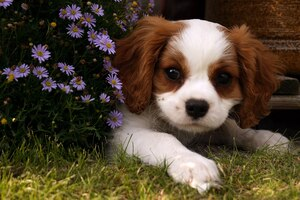

In [ ]:
fn = Path('puppy.jpg')
display.Image(filename=fn, width=200)

We create a `Chat` object as before:

In [ ]:
chat = Chat(model)

Claudia expects images as a list of bytes, so we read in the file:

In [ ]:
img = fn.read_bytes()

Prompts to Claudia can be lists, containing text, messages, or both, eg:

In [ ]:
chat([img, "In brief, what color flowers are in this image?"])

The image contains purple or lavender-colored flowers, which appear to be daisies or a similar type of flower.

<details>

- id: msg_017i7Su5rfcdcz3FmiEQ9CvD
- content: [{'text': 'The image contains purple or lavender-colored flowers, which appear to be daisies or a similar type of flower.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 185, 'output_tokens': 28}

</details>

The image is included as input tokens.

In [ ]:
chat.use

In: 185; Out: 28; Total: 213

Alternatively, Claudette supports creating a multi-stage chat with separate image and text prompts. For instance, you can pass just the image as the initial prompt (in which case Claude will make some general comments about what it sees), and then follow up with questions in additional prompts:

In [ ]:
chat = Chat(model)
chat(img)

The image shows a cute puppy lying in the grass. The puppy appears to be a Cavalier King Charles Spaniel, with a fluffy brown and white coat. The puppy is looking directly at the camera with a friendly, curious expression. In the background, there are some purple flowers, adding a nice natural setting to the scene. The image captures the adorable and playful nature of this young pup.

<details>

- id: msg_01K36rQXar93QVV5PzzaAoPr
- content: [{'text': 'The image shows a cute puppy lying in the grass. The puppy appears to be a Cavalier King Charles Spaniel, with a fluffy brown and white coat. The puppy is looking directly at the camera with a friendly, curious expression. In the background, there are some purple flowers, adding a nice natural setting to the scene. The image captures the adorable and playful nature of this young pup.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 173, 'output_tokens': 91}

</details>

In [ ]:
chat('What direction is the puppy facing?')

The puppy in the image is facing towards the camera, looking directly at the viewer.

<details>

- id: msg_013CqCFmEzPvc6mW5kAP8fki
- content: [{'text': 'The puppy in the image is facing towards the camera, looking directly at the viewer.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 275, 'output_tokens': 21}

</details>

In [ ]:
chat('What color is it?')

The puppy in the image has a brown and white coat color. It appears to be a Cavalier King Charles Spaniel breed, with the characteristic long, silky fur in those colors.

<details>

- id: msg_01XfDZDRyaNMW58TVJ9znXjR
- content: [{'text': 'The puppy in the image has a brown and white coat color. It appears to be a Cavalier King Charles Spaniel breed, with the characteristic long, silky fur in those colors.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 304, 'output_tokens': 44}

</details>

Note that the image is passed in again for every input in the dialog, so that number of input tokens increases quickly with this kind of chat.

In [ ]:
chat.use

In: 752; Out: 156; Total: 908

## XML helpers

(*Most people can probably ignore this section -- if you find yourself using XML a lot and you want a smoother experience, then read on...)

Claude works well with XML inputs, but XML can be a bit clunky to work with manually. Therefore, Claudette includes a couple of more streamlined approaches for XML generation. You don't need to use these if you don't find them useful -- you can always just use plain strings for XML directly.

An XML node contains a tag, optional children, and optional attributes. `xt` creates a tuple of these three things, which we will use to general XML shortly. Attributes are passed as kwargs; since these might conflict with reserved words in Python, you can optionally add a `_` prefix and it'll be stripped off.

In [ ]:
xt('x-custom', ['hi'], _class='bar')

('x-custom', ['hi'], {'class': 'bar'})

Claudette has functions defined for some common HTML elements to create `xt` tuples more easily, including these:

In [ ]:
from claudette.core import div,img,h1,h2,p,hr,html

In [ ]:
a = html([
    p('This is a paragraph'),
    hr(),
    img(src='http://example.prg'),
    div([
        h1('This is a header'),
        h2('This is a sub-header', style='k:v'),
    ], _class='foo')
])
a

('html',
 [('p', 'This is a paragraph', {}),
  ('hr', None, {}),
  ('img', None, {'src': 'http://example.prg'}),
  ('div',
   [('h1', 'This is a header', {}),
    ('h2', 'This is a sub-header', {'style': 'k:v'})],
   {'class': 'foo'})],
 {})

To convert a tuple data structure created with `xt` and friends into XML, use `to_xml`, adding the `hl` parameter to optionally add syntax highlighting:

In [ ]:
to_xml(a, hl=True)

```xml
<html>
  <p>This is a paragraph</p>
  <hr />
  <img src="http://example.prg" />
  <div class="foo">
    <h1>This is a header</h1>
    <h2 style="k:v">This is a sub-header</h2>
  </div>
</html>
```

JSON doesn't map as nicely to XML as the `xt` data structure, but for simple XML trees it can be convenient. The `json_to_xml` function handles that conversion:

In [ ]:
a = dict(surname='Howard', firstnames=['Jeremy','Peter'],
         address=dict(state='Queensland',country='Australia'))
print(json_to_xml(a, 'person'))

<person>
  <surname>Howard</surname>
  <firstnames>
    <item>Jeremy</item>
    <item>Peter</item>
  </firstnames>
  <address>
    <state>Queensland</state>
    <country>Australia</country>
  </address>
</person>
